<a href="https://colab.research.google.com/github/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Evaluation_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment.git@master#egg=multitask_negation_target

In [0]:
from multitask_negation_target.analysis import evaluation_metrics
import pandas as pd
import numpy as np
def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

# Evaluating Targeted Sentiment Analysis (TSA) Systems
In this notebook we evaluate the different TSA models where each model is made up of the same general architecture which is similar to the model used in [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf). The architecture is two stacked Bi-LSTM's with a connection layer from the embedding to the second Bi-LSTM. The general learning objective is to improve the Span F1 measure on extracting the targets and their respective sentiment from the text. The models differ with respect to the task and data they learn from:

1. Baseline Single Task Learning (STL) model which uses only the given TSA data.
2. Multi Task Learning (MTL) model which learns negation scope and cue detection as an auxilary task, but the main task is TSA. 

The MTL models can learn from one of two data sources:
1. [Conan Doyle stories Morante and Blanco, 2012](https://www.aclweb.org/anthology/S12-1035.pdf) 
2. [SFU a review corpus Konstantinova et al. 2012](http://www.lrec-conf.org/proceedings/lrec2012/pdf/533_Paper.pdf) taken from Epinions.com where the review domains are:
  * Books
  * Cars
  * Computers
  * Cookware
  * Hotels
  * Movies
  * Music
  * Phones 

The TSA datasets that the models will be evaluated are the **Laptop** and **Restaurant** review datasets taken from [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf) which originally come from the SemEval [2014](https://www.aclweb.org/anthology/S14-2004/), [2015](https://www.aclweb.org/anthology/S15-2082/), and [2016](https://www.aclweb.org/anthology/S16-1002/) aspect based sentiment analysis task. We took the dataset from [Li et al. 2019](https://ai.tencent.com/ailab/media/publications/A_Unified_Model_for_Opinion_Target_Extraction_and_Target_Sentiment_Prediction.pdf) so that our results are directly comparable as their dataset statistics are different from the original datasets, which is most likely due to transforming the dataset into CONLL format which is token and not span based as the original datasets are. We are also going to use the **MAMS** restuarant datastes from [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654.pdf).

The models will be compared across the following four metrics taken from [He et al. 2019](https://www.aclweb.org/anthology/P19-1048.pdf):
1. *F1-a* - F1 score of extracting the Target only ignoring the sentiment label.
2. *F1-i* - F1 score of extracting the Target and Sentiment label thus the combined/integrated task that is the TSA task.
3. *F1-s* - Macro F1 score of the sentiment labels for all correctly extracted targets.
4. *Acc-s* - Accuracy score of the sentiment labels for all correctly extracted targets.

The main metric for TSA is *F1-i*. The other metrics will probe the models performance in the relevant areas to allow better understanding of these models.

Before any of the analysis can be done the data needs to be loaded and the metrics computed:


In [0]:
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score

results_df_dict = defaultdict(list)

base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en'
model_names = ['STL', 'MTL (CD)', 'MTL (SFU)']
dataset_names = ['Restaurant', 'Laptop', 'MAMS']
split_names = ['Validation', 'Test']
for model_name in model_names:
  if model_name == 'STL':
    model_url = base_url + '/stl'
  elif model_name == 'MTL (CD)':
    model_url = base_url + '/mtl/conan_doyle'
  elif model_name == 'MTL (SFU)':
    model_url = base_url + '/mtl/sfu'
  for dataset_name in dataset_names:
    for split_name in split_names:
      if split_name == 'Test':
        if dataset_name == 'MAMS':
          result_url = model_url + f'/{dataset_name}/test.conll'
        else:
          result_url = model_url + f'/{dataset_name.lower()}/test.conll'
      elif split_name == 'Validation':
        if dataset_name == 'MAMS':
          result_url = model_url + f'/{dataset_name}/dev.conll'
        else:
          result_url = model_url + f'/{dataset_name.lower()}/dev.conll'
      for run_number in range(5):
        with tempfile.TemporaryDirectory() as temp_dir:
          temp_fp = Path(temp_dir, 'temp_file.txt')
          with temp_fp.open('w') as temp_file:
            temp_file.write(requests.get(result_url).text)
          #print(f'{model_name} {dataset_name} {split_name} {run_number} {result_url}')
          f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                            ignore_sentiment=True)
          f1_a_recall, f1_a_precision, f1_a = f1_a
          f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                            ignore_sentiment=False)
          f1_i_recall, f1_i_precision, f1_i = f1_i
          f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='POS')
          f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
          f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='NEU')
          f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
          f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='NEG') 
          f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
          f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                      metric_func=f1_score, 
                                                      average='macro')
          acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                      metric_func=accuracy_score)
          results_df_dict['Model'].append(model_name)
          results_df_dict['Dataset'].append(dataset_name)
          results_df_dict['Split'].append(split_name)
          results_df_dict['Run'].append(run_number)
          results_df_dict['F1-a'].append(f1_a)
          results_df_dict['F1-a-R'].append(f1_a_recall)
          results_df_dict['F1-a-P'].append(f1_a_precision)
          results_df_dict['F1-i'].append(f1_i)
          results_df_dict['F1-i-R'].append(f1_i_recall)
          results_df_dict['F1-i-P'].append(f1_i_precision)
          results_df_dict['F1-i-pos'].append(f1_i_pos)
          results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
          results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
          results_df_dict['F1-i-neg'].append(f1_i_neg)
          results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
          results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
          results_df_dict['F1-i-neu'].append(f1_i_neu)
          results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
          results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
          results_df_dict['F1-s'].append(f1_s)
          results_df_dict['Acc-s'].append(acc_s)

In [4]:
results_df = pd.DataFrame(results_df_dict)
not_metric_cols = ['Model', 'Dataset', 'Split', 'Run']
metric_cols = [col_name for col_name in results_df.columns.tolist() 
               if col_name not in not_metric_cols]
results_df = pd.melt(results_df, id_vars=not_metric_cols, value_vars=metric_cols, 
                     var_name='Metric', value_name='Score')
test_results_df = results_df[results_df['Split']=='Test']
val_results_df = results_df[results_df['Split']=='Validation']
results_df.head()

,Model,Dataset,Split,Run,Metric,Score
0,STL,Restaurant,Validation,0,F1-a,0.790419
1,STL,Restaurant,Validation,1,F1-a,0.790754
2,STL,Restaurant,Validation,2,F1-a,0.780073
3,STL,Restaurant,Validation,3,F1-a,0.803828
4,STL,Restaurant,Validation,4,F1-a,0.793765


## F1-I

First we shall plot the F1-I results the main metric in TSA. The results will show the overall F1-i metirc and the F1-i score for each of the sentiment labels. The top row is the test results and bottom is the validation:

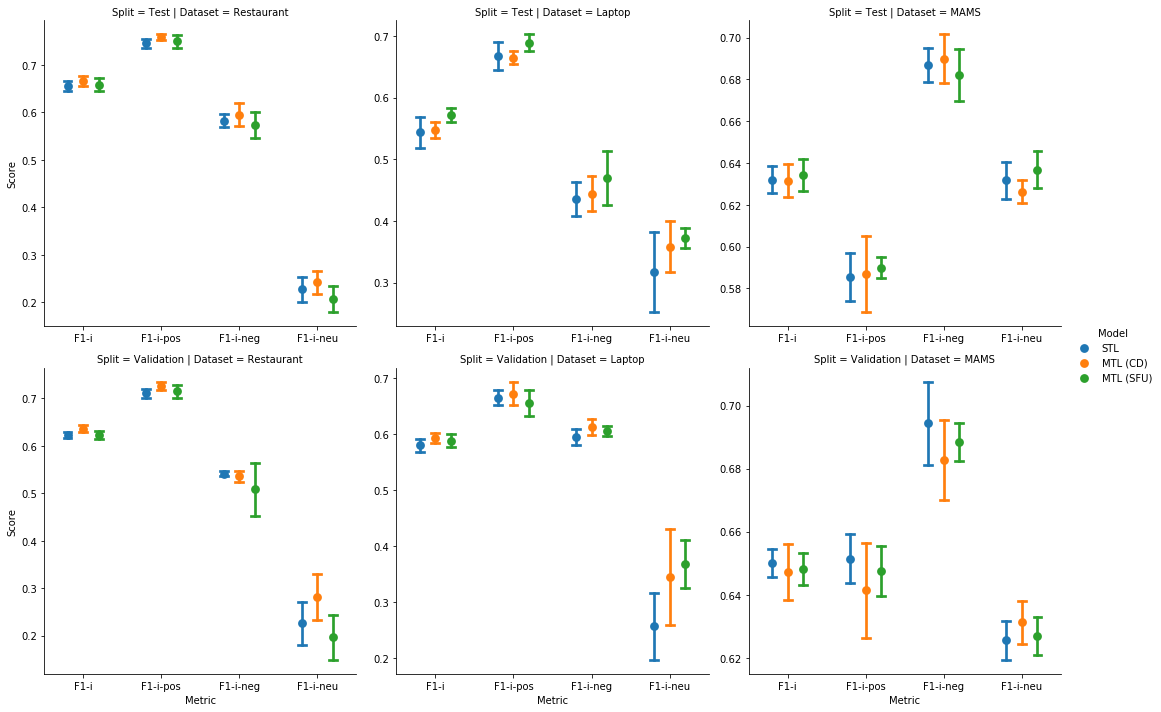

In [5]:
import seaborn as sns
ROW_ORDER=['Test', 'Validation']
f1_i_results = results_df[results_df['Metric'].isin(['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg'])]
sns.catplot(data=f1_i_results, hue='Model', row='Split', col='Dataset', x='Metric', 
            y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
            join=False, dodge=0.4, capsize=0.1, row_order=ROW_ORDER)

In [6]:
f1_i_results = results_df[results_df['Metric'].isin(['F1-i'])]
pd.pivot_table(values='Score', 
               columns=['Dataset', 'Split', 'Metric'], 
               index='Model', data=f1_i_results, aggfunc=mean_std).T

Model                             MTL (CD)     MTL (SFU)           STL
Dataset    Split      Metric                                          
Laptop     Test       F1-i    54.78 (1.32)  57.13 (1.12)  54.37 (2.56)
           Validation F1-i    59.30 (0.87)  58.77 (1.15)  57.97 (1.24)
MAMS       Test       F1-i    63.16 (0.79)  63.42 (0.76)  63.20 (0.65)
           Validation F1-i    64.72 (0.90)  64.81 (0.51)  65.01 (0.44)
Restaurant Test       F1-i    66.54 (1.06)  65.79 (1.38)  65.60 (1.06)
           Validation F1-i    63.64 (0.76)  62.30 (0.77)  62.36 (0.60)

## F1-A
The next results are for the target extraction task only with F1, Precision and Recall results:

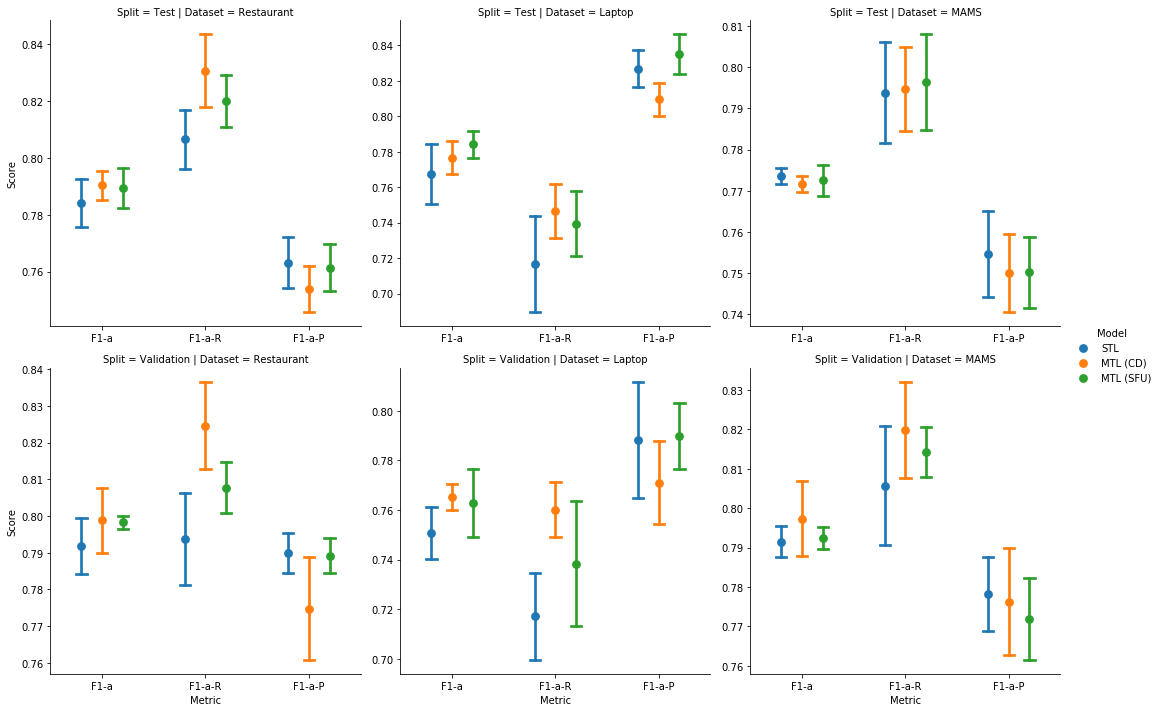

In [7]:
f1_a_results = results_df[results_df['Metric'].isin(['F1-a', 'F1-a-P', 'F1-a-R'])]
sns.catplot(data=f1_a_results, hue='Model', row='Split', col='Dataset', x='Metric', 
            y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
            join=False, dodge=0.4, capsize=0.1, row_order=ROW_ORDER)

In [8]:
f1_a_results = results_df[results_df['Metric'].isin(['F1-a'])]
pd.pivot_table(values='Score', 
               columns=['Dataset', 'Split', 'Metric'], 
               index='Model', data=f1_a_results, aggfunc=mean_std).T

Model                             MTL (CD)     MTL (SFU)           STL
Dataset    Split      Metric                                          
Laptop     Test       F1-a    77.66 (0.93)  78.41 (0.76)  76.76 (1.69)
           Validation F1-a    76.53 (0.54)  76.28 (1.38)  75.06 (1.06)
MAMS       Test       F1-a    77.16 (0.19)  77.25 (0.37)  77.36 (0.19)
           Validation F1-a    79.74 (0.95)  79.24 (0.28)  79.15 (0.39)
Restaurant Test       F1-a    79.03 (0.51)  78.95 (0.71)  78.42 (0.85)
           Validation F1-a    79.88 (0.89)  79.83 (0.17)  79.18 (0.76)

## F1-S and ACC-S

The Accuracy and Macro-F1 sentiment results where the score is based on the samples that the predicted target extraction got correct:

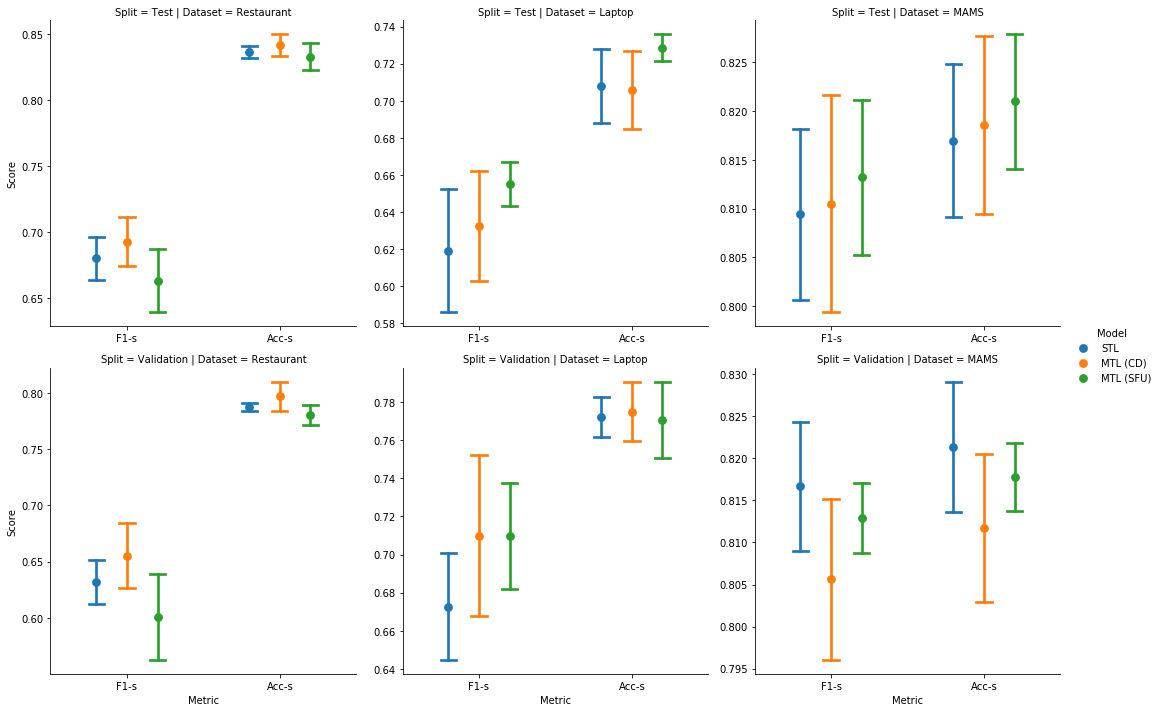

In [9]:
sentiment_results = results_df[results_df['Metric'].isin(['F1-s', 'Acc-s'])]
sns.catplot(data=sentiment_results, hue='Model', row='Split', col='Dataset', x='Metric', 
            y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
            join=False, dodge=0.4, capsize=0.1, row_order=ROW_ORDER)

In [10]:
pd.pivot_table(values='Score', 
               columns=['Dataset', 'Split', 'Metric'], 
               index='Model', data=sentiment_results, aggfunc=mean_std).T

Model                             MTL (CD)     MTL (SFU)           STL
Dataset    Split      Metric                                          
Laptop     Test       Acc-s   70.56 (2.11)  72.85 (0.73)  70.80 (2.02)
                      F1-s    63.26 (2.96)  65.49 (1.19)  61.90 (3.32)
           Validation Acc-s   77.50 (1.53)  77.07 (1.99)  77.22 (1.05)
                      F1-s    70.98 (4.22)  70.98 (2.79)  67.27 (2.80)
MAMS       Test       Acc-s   81.86 (0.92)  82.10 (0.69)  81.70 (0.79)
                      F1-s    81.05 (1.11)  81.32 (0.79)  80.94 (0.88)
           Validation Acc-s   81.17 (0.88)  81.78 (0.40)  82.14 (0.77)
                      F1-s    80.56 (0.96)  81.29 (0.42)  81.67 (0.77)
Restaurant Test       Acc-s   84.19 (0.82)  83.32 (1.03)  83.65 (0.48)
                      F1-s    69.27 (1.83)  66.31 (2.41)  68.00 (1.61)
           Validation Acc-s   79.68 (1.29)  78.04 (0.89)  78.76 (0.37)
                      F1-s    65.54 (2.90)  60.07 (3.81)  63.15 (1.94)

# Negation results

Unlike the previous results, the following are on the development/validation split of the Laptop and Restaurant datasets that have been annotated such that each target has been negated.

Below we donwload the results and convert them into a DataFrame

In [0]:
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score

negation_results_df_dict = defaultdict(list)

base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en'
model_names = ['STL', 'MTL (CD)', 'MTL (SFU)']
dataset_names = ['Restaurant', 'Laptop', 'MAMS']
for model_name in model_names:
  if model_name == 'STL':
    model_url = base_url + '/stl'
  elif model_name == 'MTL (CD)':
    model_url = base_url + '/mtl/conan_doyle'
  elif model_name == 'MTL (SFU)':
    model_url = base_url + '/mtl/sfu'
  for dataset_name in dataset_names:
    result_url = model_url + f'/{dataset_name.lower()}/dev_neg.conll'
    if dataset_name == 'MAMS':
      result_url = model_url + f'/{dataset_name}/dev_neg.conll'
    for run_number in range(5):
      with tempfile.TemporaryDirectory() as temp_dir:
        temp_fp = Path(temp_dir, 'temp_file.txt')
        with temp_fp.open('w') as temp_file:
          temp_file.write(requests.get(result_url).text)
        f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                          ignore_sentiment=True)
        f1_a_recall, f1_a_precision, f1_a = f1_a
        f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                          ignore_sentiment=False)
        f1_i_recall, f1_i_precision, f1_i = f1_i
        f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=False, 
                                              filter_by_sentiment='POS')
        f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
        f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=False, 
                                              filter_by_sentiment='NEU')
        f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
        f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                              ignore_sentiment=False, 
                                              filter_by_sentiment='NEG') 
        f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
        f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                    metric_func=f1_score, 
                                                    average='macro')
        acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                    metric_func=accuracy_score)
        negation_results_df_dict['Model'].append(model_name)
        negation_results_df_dict['Dataset'].append(dataset_name)
        negation_results_df_dict['Run'].append(run_number)
        negation_results_df_dict['F1-a'].append(f1_a)
        negation_results_df_dict['F1-a-R'].append(f1_a_recall)
        negation_results_df_dict['F1-a-P'].append(f1_a_precision)
        negation_results_df_dict['F1-i'].append(f1_i)
        negation_results_df_dict['F1-i-R'].append(f1_i_recall)
        negation_results_df_dict['F1-i-P'].append(f1_i_precision)
        negation_results_df_dict['F1-i-pos'].append(f1_i_pos)
        negation_results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
        negation_results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
        negation_results_df_dict['F1-i-neg'].append(f1_i_neg)
        negation_results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
        negation_results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
        negation_results_df_dict['F1-i-neu'].append(f1_i_neu)
        negation_results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
        negation_results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
        negation_results_df_dict['F1-s'].append(f1_s)
        negation_results_df_dict['Acc-s'].append(acc_s)

In [12]:
negation_results_df = pd.DataFrame(negation_results_df_dict)
not_metric_cols = ['Model', 'Dataset', 'Run']
metric_cols = [col_name for col_name in negation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
negation_results_df = pd.melt(negation_results_df, id_vars=not_metric_cols, 
                              value_vars=metric_cols, var_name='Metric', 
                              value_name='Score')
negation_results_df.head()

,Model,Dataset,Run,Metric,Score
0,STL,Restaurant,0,F1-a,0.786925
1,STL,Restaurant,1,F1-a,0.780906
2,STL,Restaurant,2,F1-a,0.780193
3,STL,Restaurant,3,F1-a,0.786683
4,STL,Restaurant,4,F1-a,0.779252


## F1-I

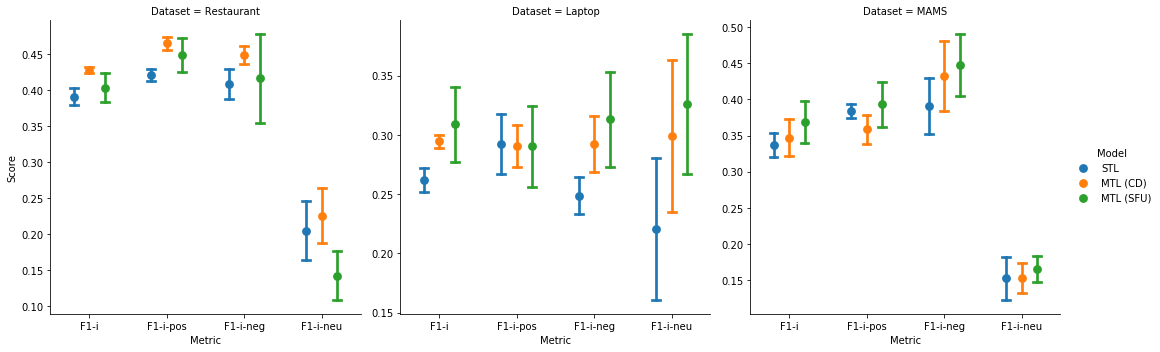

In [13]:
f1_i_negation_results = negation_results_df[negation_results_df['Metric'].isin(['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg'])]
sns.catplot(data=f1_i_negation_results, hue='Model', col='Dataset', x='Metric', 
            y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
            join=False, dodge=0.4, capsize=0.1)

In [14]:
f1_i_negation_results = negation_results_df[negation_results_df['Metric'].isin(['F1-i'])]
pd.pivot_table(values='Score', 
               columns=['Dataset', 'Metric'], 
               index='Model', data=f1_i_negation_results, aggfunc=mean_std).T

,Model,MTL (CD),MTL (SFU),STL
Dataset,Metric,,,
Laptop,F1-i,29.46 (0.55),30.87 (3.13),26.19 (1.04)
MAMS,F1-i,34.70 (2.54),36.86 (2.88),33.65 (1.69)
Restaurant,F1-i,42.80 (0.44),40.29 (2.01),39.06 (1.22)


Compared to the non-negation results the largest difference is in the Laptop results where there is a difference of 25-30 F1 score. In the Restaurant it is close to the 20-25 F1 score difference. Very large differences!

## F1-A

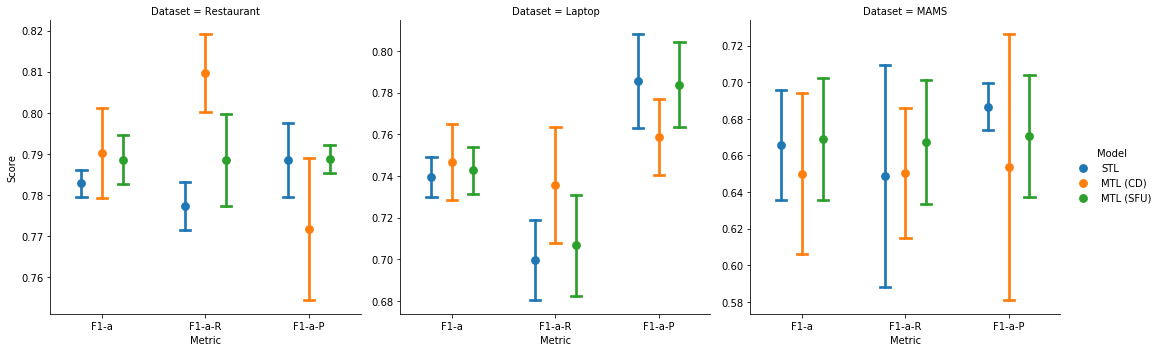

In [15]:
f1_a_negation_results = negation_results_df[negation_results_df['Metric'].isin(['F1-a', 'F1-a-P', 'F1-a-R'])]
sns.catplot(data=f1_a_negation_results, hue='Model', col='Dataset', x='Metric', 
            y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
            join=False, dodge=0.4, capsize=0.1)

In [16]:
f1_a_negation_results = negation_results_df[negation_results_df['Metric'].isin(['F1-a'])]
pd.pivot_table(values='Score', 
               columns=['Dataset', 'Metric'], 
               index='Model', data=f1_a_negation_results, aggfunc=mean_std).T

,Model,MTL (CD),MTL (SFU),STL
Dataset,Metric,,,
Laptop,F1-a,74.66 (1.82),74.27 (1.13),73.96 (0.96)
MAMS,F1-a,65.00 (4.38),66.89 (3.33),66.57 (2.99)
Restaurant,F1-a,79.01 (1.10),78.86 (0.60),78.28 (0.33)


We can see the difference in the F1-I score cannot be due to the extraction task as there is almost no difference for the Restaurant and Laptop datasets compared to the non-negation results.

## F1-S and ACC-S

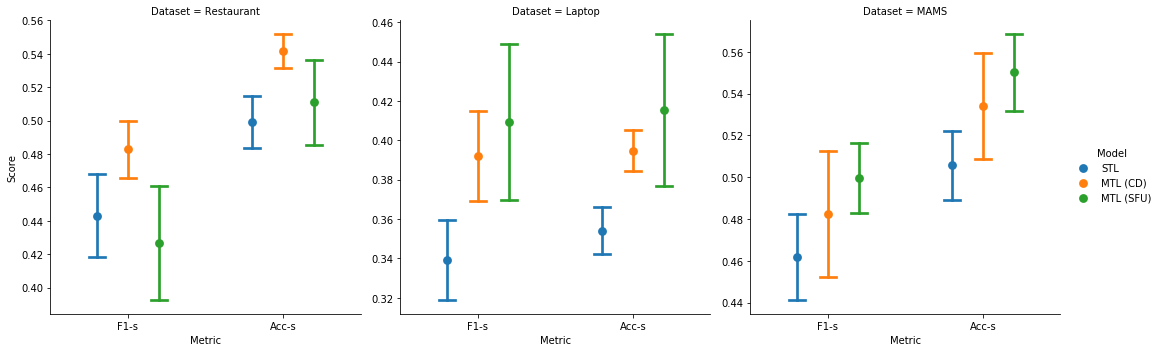

In [17]:
sentiment_negation_results = negation_results_df[negation_results_df['Metric'].isin(['F1-s', 'Acc-s'])]
sns.catplot(data=sentiment_negation_results, hue='Model', col='Dataset', x='Metric', 
            y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
            join=False, dodge=0.4, capsize=0.1)

In [18]:
pd.pivot_table(values='Score', 
               columns=['Dataset', 'Metric'], 
               index='Model', data=sentiment_negation_results, 
               aggfunc=mean_std).T

Model                  MTL (CD)     MTL (SFU)           STL
Dataset    Metric                                          
Laptop     Acc-s   39.47 (1.06)  41.54 (3.87)  35.40 (1.20)
           F1-s    39.19 (2.29)  40.94 (3.96)  33.90 (2.04)
MAMS       Acc-s   53.42 (2.54)  55.02 (1.84)  50.57 (1.66)
           F1-s    48.23 (3.00)  49.94 (1.67)  46.17 (2.07)
Restaurant Acc-s   54.18 (1.02)  51.10 (2.55)  49.90 (1.57)
           F1-s    48.29 (1.71)  42.66 (3.43)  44.32 (2.48)

As suggested from the F1-A results the main difference is in the sentiment metrics. As can be seen the MTL models generally perform better on the negation data espically the Conan Doyle more, the difference between the MTL models and the STL is much larger when applied to the negation data.